# Courses recommendation system
# III. Create models

This is the third part of the Udacity Data Science Nanodegree capstone project, which consists in the creation of a course recommendation system.

In this part, I will create models from which I will make the recommendations.


## 1 Import libraries

In [7]:
import os
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline

from db_utils import connection 
from common import requested_courses

import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

## 2 Retrieve data
In this step I will retrieve the clean data from database.

### 2.1 Retrieve courses

In [3]:
courses_query = '''SELECT c.*, cat.name AS category_name FROM courses c 
                    JOIN categories cat ON c.category_id = cat.id'''

courses_df = pd.read_sql_query(courses_query, con=connection())

### 2.2 Retrieve leads

In [4]:
leads_query = 'SELECT * FROM clean_leads ORDER BY created_on DESC'

leads_df = pd.read_sql_query(leads_query, con=connection())

### 2.3 Retrieve reviews

In [5]:
reviews_query = 'SELECT * FROM clean_reviews ORDER BY created_on DESC'

reviews_df = pd.read_sql_query(reviews_query, con=connection())

## 3 Create a course content similarity matrix

I will create a similarity matrix for courses content. I will use the title and the description to compare the courses with each other. In the matrix, columns and rows indexes will be the course id and the intersection will be the similarity between them. The range of values will be between 0 and 1, where 0 means totally different and 1 means that the content is identical.

In [17]:
def create_similarity_matrix(df, sample_len=None):
    """ 
    Creates a course similarity matrix
    
    :param df DataFrame: courses dataframe. Must include title and description columns
    :param sample_len: Maximum number of courses used to create the matrix. If `None`, all courses in DataFrame
            will be used.
    :return np.ndarray: An m x m matrix representing the course similarities, where m is the number of courses.
        Example of a similarity matrix:
        
         [[0.99999994 0.         0.13075474 0.02665992]
          [0.         1.         0.00812627 0.00331377]
          [0.13075474 0.00812627 1.         0.0069054 ]
          [0.02665992 0.00331377 0.0069054  1.        ]]
          
        rows and columns represents a course, the elements in the matrix, represent the similarity between them.
    """
    if not sample_len:
        course_content = df['title'].str.cat(df['description'], sep='. ').values
    else:
        course_content = df['title'].str.cat(df['description'], sep='. ').head(sample_len).values
    
    model = Pipeline([
        ('norm', TextNormalizer()),
        ('sim', Similarity())
    ])
    
    return model.fit_transform(course_content)
    
    
def create_similarity_df(df, min_similarity=0.5, sample_len=None):
    """
    Creates a course similarity DataFrame from a similarity matrix
    
    :param df DataFrame: Courses dataframe. Must include title and description columns
    :param min_similarity float: Minimum similarity to be included in DataFrame
    :param sample_len int: Maximum number of courses that will be included in the matrix
    
    :return DataFrame: a dataframe with following columns:
        a_course str: course id
        another_course str: course id
        similarity float: similarity between courses
    """
    sim_list = []
    sim_matrix = create_similarity_matrix(df, sample_len=sample_len)
    
    for idx, similarities in enumerate(sim_matrix):
        a_course_id = df.iloc[idx]['id']
        
        for idx_sims, sim_score in enumerate(similarities):
            if idx == idx_sims:
                continue

            if sim_score < min_similarity:
                continue

            another_course_id = df.iloc[idx_sims]['id']

            sim_list.append({'a_course_id': a_course_id, 
                             'another_course_id': another_course_id, 
                             'similarity': sim_score})

    return pd.DataFrame(sim_list)

I will create a similarity matrix with a sample of 50 courses

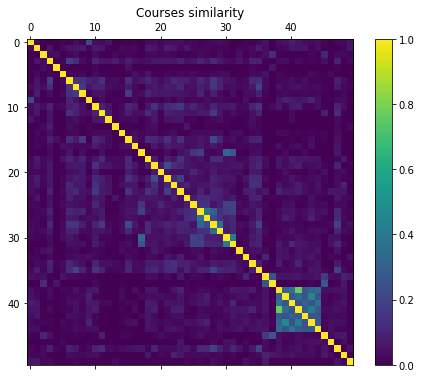

In [18]:
sims = create_similarity_matrix(courses_df, sample_len=50)

fig, ax = plt.subplots(figsize=(8, 6))

cax = ax.matshow(sims, interpolation='nearest')
fig.colorbar(cax)
ax.set_title('Courses similarity')

plt.show();

The similarity dataframe will look like this:

In [19]:
sims_df_s50 = create_similarity_df(courses_df, sample_len=50)
sims_df_s50.head()

,a_course_id,another_course_id,similarity
0,170037187,170037258,0.772166
1,170037258,170037187,0.772166


### 3.1 Create courses content similarity DataFrame
And now, I will create the similarities dataframe with the entire courses dataframe. <span style="color:red">**This process took approximately 8 hours on a MacBook pro (2.3 GHz Intel Core i5, 16 GB RAM)**</span>

In [20]:
sims_df = create_similarity_df(courses_df)

In [27]:
sims_df.head()

,a_course_id,another_course_id,similarity
0,170565193,170566126,0.606849
1,170563091,170263714,0.724279
2,170563091,170203253,0.548920
3,170563091,170008122,0.644050
4,170563091,170563098,0.827058


In [28]:
sims_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74110 entries, 0 to 74109
Data columns (total 3 columns):
a_course_id          74110 non-null int64
another_course_id    74110 non-null int64
similarity           74110 non-null float64
dtypes: float64(1), int64(2)
memory usage: 1.7 MB


### 3.2 Save courses similarities into the database

In [29]:
conn = connection()

sql_drop = 'DROP TABLE IF EXISTS `courses_similarities`'
conn.execute(sql_drop)

sql_create = """CREATE TABLE `courses_similarities` (
  `a_course_id` varchar(9) NOT NULL,
  `another_course_id` varchar(9) NOT NULL,
  `similarity` double NOT NULL,
  PRIMARY KEY (`a_course_id`, `another_course_id`)
) ENGINE=InnoDB DEFAULT CHARSET=utf8
"""
conn.execute(sql_create)

# Save course similarities to database
sims_df.to_sql('courses_similarities', con=conn, if_exists='append', index=False)

## 4 Create the user-item matrices
Now, I will create the user item matrices. There will be a matrix relating users to ratings, and another that relates users to leads.

In [5]:
def create_ratings_user_item_matrix(df=reviews_df):
    """Creates a ratings user-item matrix DataFrame reviews

    :return: A DataFrame representing the ratings user-item matrix
    """
    user_items = df[['user_id', 'course_id', 'rating']]

    return user_items.groupby(['user_id', 'course_id'])['rating'].max().unstack()

def create_leads_user_item_matrix(df=leads_df):
    """Creates a leads user-item matrix DataFrame reviews

    :return: A DataFrame representing the leads user-item matrix
    """
    user_items = df[['user_id', 'course_id']]

    user_item_matrix = user_items.groupby(['user_id', 'course_id'])['course_id'].max().unstack()
    user_item_matrix = user_item_matrix.where(user_item_matrix.isnull(), other=1)
    user_item_matrix = user_item_matrix.fillna(0)

    return user_item_matrix

In [9]:
ratings_user_item_matrix = create_ratings_user_item_matrix(reviews_df)
leads_user_item_matrix = create_leads_user_item_matrix(leads_df)

### 4.1 Save the matrices to csv files

In [10]:
leads_user_item_matrix.to_csv('../data/leads_matrix.csv')
ratings_user_item_matrix.to_csv('../data/ratings_matrix.csv')

### 4.2 Checking the files size

In [12]:
leads_file_stats = os.stat('../data/leads_matrix.csv')
ratings_file_stats = os.stat('../data/ratings_matrix.csv')

print('Leads matrix size is {:.2f} MB'.format(leads_file_stats.st_size / (1024 * 1024)))
print('Ratings matrix size is {:.2f} MB'.format(ratings_file_stats.st_size / (1024 * 1024)))

Leads matrix size is 516.91 MB
Ratings matrix size is 254.21 MB


The user-item matrices seems to be too heavy (about 500MB and 255MB) to be loaded  on every request of a web application or an API. To overcome this problem, I will create 'pre-baked' recommendation structures, that is, all recommendations for each user and course. The disadvantage of this strategy is that it will be necessary to execute the generation processes of these structures very frequently to keep the data updated.

**Create a course-course recommendation DataFrame**

This type of recommendation uses the leads generated by users on courses. This will be useful for each course to have a section called "Users who requested information about this course were also interested in...".That section will be very helpful for new users without information request history.

This DataFrame will have two columns: column `course` represents the courses that have generated a lead and column `recommended`, where we will have the courses in which the same user who generated a lead in the courses of column `course` also generated leads.

In [140]:
def course_course_recommendations(course_id, user_item_matrix, max_recs=10):
    """Returns an array of recommended courses based on leads generated in one course

    :param course_id: Course id for which we want to make the recommendations
    :param user_item_matrix: Leads user-item matrix
    :param max_recs: Maximum number of recommendations
    :return numpy.array: Array of courses recommended based on generated leads in one course
    """
    users = np.array(user_item_matrix[user_item_matrix.loc[:, course_id] == 1].index)
    recs = np.array([])

    for user_id in users:
        user_courses = requested_courses(user_id, leads_df)

        new_recs = user_courses[user_courses != course_id]
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))

        if len(recs) > max_recs:
            break

    return recs[:max_recs]

In [17]:
recommendations = []
for course in leads_user_item_matrix.columns:
    recs = course_course_recommendations(course, leads_user_item_matrix)
    for rec in recs:
        recommendations.append({'course': course, 'recommended': rec})

course_course_recs_df = pd.DataFrame(recommendations)

In [18]:
course_course_recs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29469 entries, 0 to 29468
Data columns (total 2 columns):
course         29469 non-null object
recommended    29469 non-null object
dtypes: object(2)
memory usage: 460.5+ KB


**Save recommendations to database**

In [19]:
conn = connection()

sql_drop = 'DROP TABLE IF EXISTS `recommended_courses_by_leads`'
conn.execute(sql_drop)

sql_create = """CREATE TABLE `recommended_courses_by_leads` (
  `course` varchar(9) NOT NULL,
  `recommended` varchar(9) NOT NULL,
  PRIMARY KEY (`course`, `recommended`)
) ENGINE=InnoDB DEFAULT CHARSET=utf8
"""
conn.execute(sql_create)

# Save recommendations to database
course_course_recs_df.to_sql('recommended_courses_by_leads', con=conn, if_exists='append', index=False)

## 5 Neighborhood based collaborative filtering using leads data
### 5.1 The matrix sparsity problem
If we want to recommend courses to a user based on leads generated by other users, the problem gets worse. We have a matrix with 26186 users and 10331 courses, so we have more than 270 million cells, most of which with zero value (only 37085 filled with non-zero values).

In [20]:
leads_user_item_matrix.shape

(26186, 10331)

In [21]:
leads_user_item_matrix.shape[0] * leads_user_item_matrix.shape[1]

270527566

In [22]:
# Count non-zero values
(leads_user_item_matrix != 0).sum().sum()

37085

This causes two problems:

As I said before, we would need around 500MB memory to store the matrix. The second problem is that we need to perform operations on this matrix and the execution time of these operations would be very long.

Since the bulk of the computation performed will involve adding or multiplying zero values together, we could perform the calculations only when there is a connection between the user and the course, that is when the cell value is 1.

The solution to representing and working with sparse matrices is to use an alternate data structure to represent the sparse data.

SciPy provides an [implementation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) for creating sparse matrix from multiple structures.

I will create a sparse matrix from the `leads_user_item_matrix`:

In [23]:
sp_user_item_matrix = csr_matrix(leads_user_item_matrix.values, dtype='int8')
sp_user_item_matrix

<26186x10331 sparse matrix of type '<class 'numpy.int8'>'
	with 37085 stored elements in Compressed Sparse Row format>

In [24]:
print(sp_user_item_matrix)

  (0, 6556)	1
  (0, 6864)	1
  (0, 8165)	1
  (0, 9224)	1
  (1, 5944)	1
  (2, 8081)	1
  (3, 10232)	1
  (4, 10059)	1
  (5, 8159)	1
  (6, 293)	1
  (7, 6887)	1
  (8, 8843)	1
  (9, 9486)	1
  (10, 9855)	1
  (11, 5926)	1
  (12, 10232)	1
  (13, 10041)	1
  (14, 9094)	1
  (15, 4456)	1
  (16, 10041)	1
  (17, 10244)	1
  (18, 9181)	1
  (19, 1708)	1
  (19, 3784)	1
  (19, 3793)	1
  :	:
  (26163, 9055)	1
  (26164, 6535)	1
  (26165, 2569)	1
  (26166, 3669)	1
  (26167, 9058)	1
  (26168, 6090)	1
  (26169, 91)	1
  (26170, 9181)	1
  (26171, 3068)	1
  (26172, 10283)	1
  (26173, 7578)	1
  (26174, 10244)	1
  (26175, 10035)	1
  (26176, 1629)	1
  (26177, 2175)	1
  (26178, 1730)	1
  (26179, 9181)	1
  (26180, 3103)	1
  (26180, 9896)	1
  (26181, 7339)	1
  (26182, 9655)	1
  (26183, 6611)	1
  (26184, 10198)	1
  (26185, 365)	1
  (26185, 3825)	1


We see how the csr_matrix looks, the first element of tuple is the row index (users) and the second one is the column (courses) the value represents the relation between users and courses, in this case all values are 1.

The next step is to create a user-courses map, a dictionary whose keys are user ids and values ​​the matrix corresponding to that user.

In [25]:
user_leads_courses_map = {}
for i in range(0, sp_user_item_matrix.shape[0]):
    user_leads_courses_map[leads_user_item_matrix.index[i]] = sp_user_item_matrix[i]

In [26]:
with open('../data/user_courses_map.pickle', 'wb') as filename:
    pickle.dump(user_leads_courses_map, filename)


In [27]:
file = os.stat('../data/user_courses_map.pickle')

print('Leads matrix size is {:.2f} MB'.format(file.st_size / (1024 * 1024)))

Leads matrix size is 6.38 MB


6.38 MB vs. 516.91 MB, the improvement is amazing.

## 6 Neighborhood based collaborative filtering using ratings

### 6.1 Measuring distances between users

To get the nearest neighbours of each user, I need to calculate the distance between each user and every other user. To get this measure, I will use the Euclidean Distance.

In [143]:
def rated_courses(user_id, lower_bound=2):
    """Returns an array of course ids rated by a user
    
    :param user_id: User identifier
    :param lower_bound: Minimum number of rated courses a user must have
    :return: Array of courses rated by a user
    """
    courses = reviews_df[reviews_df['user_id'] == user_id]['course_id'].values
    
    if len(courses) >= lower_bound:
        return courses
    
    return np.array([])

def courses_liked(user_id, min_rating=7):
    """Returns an array of courses rated by a user with a rating higher than `min_rating`
    
    :param user_id str: User id for which we want to find courses rated
    :return array: Array of course ids rated by a user
    """
    return reviews_df[(reviews_df['user_id'] == user_id) & (reviews_df['rating'] >= min_rating)]['course_id'].values

In [113]:
def compute_euclidean_distance(a_user_id, another_user_id, ratings_user_item_matrix):
    """Computes the euclidean distance between users taking into account the rated courses
    
    :param a_user_id str: Id of a user
    :param another_user_id str: Id of another user
    :param user_item_matrix DataFrame: The reviews user-item matrix
    :return float: The eculidean distance between the users
    """
    a_user_courses = rated_courses(a_user_id)
    another_user_courses = rated_courses(another_user_id)
    
    similar_courses = np.intersect1d(a_user_courses,
                                     another_user_courses, 
                                     assume_unique=True)
    
    # there's no courses in common
    if len(similar_courses) == 0:
        return np.nan
    
    df = ratings_user_item_matrix.loc[(a_user_id, another_user_id), similar_courses]
    
    return np.linalg.norm(df.loc[a_user_id] - df.loc[another_user_id])


**Create a user distances DataFrame**

<span style="color:red">**This process consumes a lot of time and resources**</span>

In [114]:
distances = []

for user_id in ratings_user_item_matrix.index:
    for another_user_id in ratings_user_item_matrix.index:
        if user_id == another_user_id:
            continue
            
        try: 
            distance = compute_euclidean_distance(user_id,
                                                  another_user_id,
                                                  ratings_user_item_matrix)
        except KeyError:
            continue

        if np.isnan(distance):
            continue

        distances.append({'a_user_id': user_id, 'another_user_id': another_user_id, 'eucl_distance': distance})
        
eucl_distances_df = pd.DataFrame(distances)

After hours of data processing, I only obtained about 100 distance measurements between users from 11 unique users, why?

In the previous section, we could see that only 6% of users rates more than one course. Distance between users calculation is very expensive (to calculate them all, almost 700 million operations are necessary). Therefore, since we cannot recommend courses to 94% of users, I have decided **not to use this type of recommendation system**.

## 6 Model based collaborative filtering
In this part I will use the leads user-item matrix. Since there are no nan values in that matrix, I can use Singular Value Decomposition from numpy on the matrix.

### 6.1 Perform SVD

**Get the leads user-item matrix**

In [52]:
leads_user_item_matrix = pd.read_csv('../data/leads_matrix.csv').set_index('user_id')

In [57]:
u, s, vt = np.linalg.svd(leads_user_item_matrix)
s.shape, u.shape, vt.shape

((10331,), (26186, 26186), (10331, 10331))

### 6.2 Choose the appropriate number of latent features

I will start by testing how it would work with an increasingly high number of latent features.

In [58]:
num_latent_feats = np.arange(10,1500,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(leads_user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    

In the following plot we will see how the accuracy improves as we increase the number of lantent features.

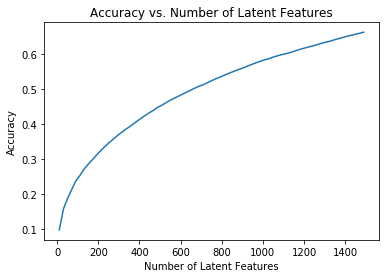

In [59]:
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/leads_df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

To be sure how many features to use, 

In [64]:
def create_user_item_matrix(df=leads_df):
    """Creates a leads user-item matrix DataFrame reviews

    :return: A DataFrame representing the leads user-item matrix
    """
    user_items = df[['user_id', 'course_id']]

    user_item_matrix = user_items.groupby(['user_id', 'course_id'])['course_id'].max().unstack()
    user_item_matrix = user_item_matrix.where(user_item_matrix.isnull(), other=1)
    user_item_matrix = user_item_matrix.fillna(0)

    return user_item_matrix

def train_test_split(df, train_size=.8, test_size=.2):
    df_size = df.shape[0]
    
    train_size = int(np.floor(df_size * train_size))
    test_size = int(np.floor(df_size * test_size))
    
    train_set = df.head(train_size)
    test_set = df.tail(test_size)
    
    train_user_item = create_user_item_matrix(train_set)
    test_user_item = create_user_item_matrix(test_set)
    
    
    return train_user_item, test_user_item

In [65]:
train_user_item, test_user_item = train_test_split(leads_df)

In [66]:
train_idx = train_user_item.index.values
train_courses = train_user_item.columns.values
test_idx = test_user_item.index.values
test_courses = test_user_item.columns.values

n_users_preds = len(np.intersect1d(test_idx, train_idx))
cold_start_users = len(test_idx) - n_users_preds

n_courses_preds = len(np.intersect1d(test_courses, train_courses))
cold_start_courses = len(test_courses) - n_courses_preds

print('Users we can make predictions for: {}\n' \
      'Users we cannot make predictions for: {}\n' \
      'Courses we can make predictions for: {}\n' \
      'Courses we cannot make predictions for: {}\n'.format(n_users_preds, cold_start_users, n_courses_preds, cold_start_courses))

Users we can make predictions for: 131
Users we cannot make predictions for: 5360
Courses we can make predictions for: 2234
Courses we cannot make predictions for: 1410



In [71]:
def predictions(u, s, vt, k):
    '''
    INPUT:
    u - user feature matrix
    s - test dataframe
    vt - item feature matrix
    k - number of latent features to keep
    
    OUTPUT:
    user_item_matrix - a predictions user-item matrix
    
    '''
    
    s_new = np.diag(s[:k])
    u_new = u[:, :k]
    vt_new = vt[:k, :]
    
    user_item_matrix = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    return user_item_matrix

In [67]:
u_train, s_train, vt_train = np.linalg.svd(train_user_item)
u_train.shape, s_train.shape, vt_train.shape

((20821, 20821), (8920,), (8920, 8920))

In [68]:
common_user_ids = train_user_item.index.isin(test_idx)
common_courses_ids = train_user_item.columns.isin(test_courses)

u_test = u_train[common_user_ids, :]
vt_test = vt_train[:, common_courses_ids]

u_test.shape, vt_test.shape

((131, 20821), (8920, 2234))

In [69]:
test_user_item = test_user_item.loc[np.intersect1d(test_idx, train_idx), np.intersect1d(test_courses, train_courses)]

In [72]:
num_latent_feats = np.arange(5,800,10)
sum_errs_train = []
sum_errs_test = []

for k in num_latent_feats:
    # restructure with k latent features
    user_train_preds = predictions(u_train, s_train, vt_train, k)
    user_test_preds = predictions(u_test, s_train, vt_test, k)
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(train_user_item, user_train_preds)
    diffs_test = np.subtract(test_user_item, user_test_preds)
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    
    sum_errs_train.append(err_train)
    sum_errs_test.append(err_test)

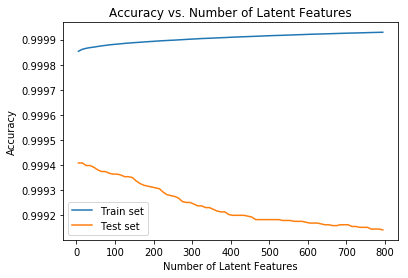

In [73]:
plt.plot(num_latent_feats, 1 - (np.array(sum_errs_train)/(train_user_item.shape[0]*train_user_item.shape[1])), label='Train set');
plt.plot(num_latent_feats, 1 - (np.array(sum_errs_test)/(test_user_item.shape[0]*test_user_item.shape[1])), label='Test set');

plt.legend(loc='best')
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.show();

We see how accuracy decreases when the number of features increases. This must be due to the low number of users that are in both the test set and training set. With this model, we can only make recommendations to 131 users. Therefore, **I won't use the model based collaborative filtering**.

## 7 Conclusions